This is an older notebook where we tried to predict if there was a hand present in an image. It turns out this really was not very helpful.

Also, note that this notebook uses [11K Images of hands](https://sites.google.com/view/11khands) which is not used in the other notebooks.

In [1]:
import numpy as np
import pandas as pd

import imgaug as ia
from imgaug import augmenters as iaa
from keras.preprocessing.image import img_to_array, load_img, array_to_img

import matplotlib.pyplot as plt
import scipy.io

import cv2
import os

/usr/local/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
#### SETTINGS
IMAGE_SHAPE=(150, 150)
CLEAR_EXISTING_IMAGES = True
#LIMIT_DATA = 40
LIMIT_DATA = -1
PERFORM_AUGMENTATION = True

FORCE_SQUARE_ANNOTATIONS = True # The "hands" dataset rotates the annotations to fit the hand in action poses, which does not align with LISA hands dataset



In [3]:
#### FilePath Information
DATA_PATH = '../../data'

LISA_HAND_DATASET = os.path.join(DATA_PATH, 'original/lisa_hands/train')

HANDS_DATASET = os.path.join(DATA_PATH, 'original/hand_dataset')
IMAGE_TRAIN_DIR = os.path.join(HANDS_DATASET, 'training_dataset/training_data')
IMAGE_TEST_DIR = os.path.join(HANDS_DATASET, 'test_dataset/test_data')
IMAGE_VAL_DIR = os.path.join(HANDS_DATASET, 'validation_dataset/validation_data')
# TODO: Add testing and validation

img_shape_path = '{}X{}'.format(IMAGE_SHAPE[0], IMAGE_SHAPE[1])
NEW_HANDS_ANNOTATED_DATASET = os.path.join(DATA_PATH, 'fabricated/hands_annotated_dataset', img_shape_path)
NEW_HANDS_TRAIN = os.path.join(NEW_HANDS_ANNOTATED_DATASET, 'training')
NEW_HANDS_TEST = os.path.join(NEW_HANDS_ANNOTATED_DATASET, 'test')
NEW_HANDS_VAL = os.path.join(NEW_HANDS_ANNOTATED_DATASET, 'validation')
                                  
IMAGES_SUB_DIR = 'images'
ANNOTATIONS_SUB_DIR = 'annotations'
# TODO: Add testing and validation



In [4]:
NEW_HANDS_ANNOTATED_DATASET

'../../data/fabricated/hands_annotated_dataset/150X150'

### Load annotations and images

In [5]:
def load_txt_annotations_from_file(file):
    possible_hands = ['leftHand_driver', 'rightHand_driver', 'leftHand_passenger', 'rightHand_passenger']
    hand_positions = []
    with open(file, 'r') as f:
        content = f.read().strip()
        lines = content.split('\n')
        # ignore the first line which just contains the version
        driver_lines = lines[1:]
        driver_hand_name_hash = {}
        for line in driver_lines:
            line_word_split = line.split(' ')
            driver_hand_name = line_word_split[0]
            # ignore the first item (that's the driver hand name) and we just want the four afterwards
            # ...everything after that seems to always be "0"
            driver_hand_name_hash[driver_hand_name] = line_word_split[1:5]
        for hand_name in possible_hands:
            # nothing exists for this driver so we will just let it be empty
            if hand_name not in driver_hand_name_hash:
                hand_positions.append([[0, 0], [0, 0], [0, 0], [0, 0]])
                continue
            hand_string_points = driver_hand_name_hash[hand_name]
            hand = [int(point) for point in hand_string_points]

            x1 = hand[0]
            y1 = hand[1]
            width = hand[2]
            height = hand[3]
            point1 = [x1, y1]
            point2 = [x1+width, y1]
            point3 = [x1+width, y1+height]
            point4 = [x1, y1+height]
            hand_positions.append([point1, point2, point3, point4])
        return hand_positions
        
load_txt_annotations_from_file('../../data/original/lisa_hands/train/posGt/1_0000004_0_0_0_6.txt')

[[[267, 337], [563, 337], [563, 504], [267, 504]],
 [[0, 0], [0, 0], [0, 0], [0, 0]],
 [[0, 0], [0, 0], [0, 0], [0, 0]],
 [[0, 0], [0, 0], [0, 0], [0, 0]]]

In [6]:
def load_matlab_annotations_from_file(file):
    f = scipy.io.loadmat(file)
    data = f.get('boxes')
    data = np.array(data)
    
    # We only want the rectangular points from each annotation
    image_annotations = []
    for hand in data[0]:
        # I'm not entirely sure why, but the shape of each file seems to be wrapped in a lot of empty lists
        polygon_points = hand[0][0]
        # We only want the first four items (that actually make up the polygon)
        polygon_points = list(polygon_points)[:4]
        # Again, each point has an empty list wrapped around
        polygon_points = [point[0] for point in polygon_points]
        # points are actually reversed, we want them to be [x, y], but matlab really likes them as [y, x]
        image_annotations.append([[point[1], point[0]] for point in polygon_points])
        

    return image_annotations
load_matlab_annotations_from_file('../../data/original/hand_dataset/training_dataset/training_data/annotations/Buffy_3.mat')

[[[340.85546247104276, 490.84806633976746],
  [349.14453752895724, 465.15193366023254],
  [380.14453752895724, 475.15193366023254],
  [371.85546247104276, 500.84806633976746]],
 [[385.2176972186857, 456.3696162031143],
  [416.7823027813143, 461.6303837968857],
  [410.7823027813143, 497.6303837968857],
  [379.2176972186857, 492.3696162031143]]]

In [7]:
img_ORIGINAL = cv2.imread('../../data/original/hand_dataset/training_dataset/training_data/images/Buffy_3.jpg')
img_ORIGINAL.shape

(708, 617, 3)

In [8]:
def rotate_hand_annotation(hand):
    # use the most extreme values so that we can find the most reasonable replacement
    left = 100000
    right = 0
    top = 100000
    bottom = 0
    for points in hand:
        x, y = points
        if x < left:
            left = x
        if x > right:
            right = x
        if y < top:
            top = y
        if y > bottom:
            bottom = y
    new_hand = [
        # start with the top left
        [left, top],
        # then top right
        [right, top],
        # then bottom right
        [right, bottom],
        # then bottom left        
        [left, bottom]
    ]
        
    return new_hand
def rotate_hands_annotation(hands):
    return [rotate_hand_annotation(hand) for hand in hands]

In [9]:
def get_filename_extension(filename):
    filename, file_extension = os.path.splitext(filename)
    return file_extension
def get_hand_counts(annotations):
    hand_counts = [len(annotation) for annotation in annotations]
    return hand_counts

def get_hand_dimensions(annotations):
    hand_dimensions = {
        'width': [],
        'height': []
    }
    for annotation in annotations:
        for hand in annotation:
            left, top = hand[0]
            right, bottom = hand[2]

            width = right - left
            height = bottom - top
            
            hand_dimensions['width'].append(width)
            hand_dimensions['height'].append(height)
            
    return hand_dimensions

def load_annotations_from_dir(annotations_dir):
    annotation_files = sorted(os.listdir(annotations_dir))
    annotations_for_all_files = []
    i = 0
    for annotation_file in annotation_files:
        if LIMIT_DATA > -1 and i == LIMIT_DATA:
            break
        # ignore config files
        if annotation_file.find('.') == 0:
            continue

        filepath = os.path.join(annotations_dir, annotation_file)
        filename_extension = get_filename_extension(annotation_file)
        annotations = []

        if filename_extension == '.mat':
            annotations = load_matlab_annotations_from_file(filepath)
            if FORCE_SQUARE_ANNOTATIONS:
                annotations = rotate_hands_annotation(annotations)
        elif filename_extension == '.txt':
            annotations = load_txt_annotations_from_file(filepath)
        elif filename_extension == '.ext':
            continue
        else:
            raise Exception('Unknown filename extension {}'.format(filename_extension))

        annotations_for_all_files.append(annotations)
        i += 1
    hand_counts = get_hand_counts(annotations_for_all_files)
    hand_dimensions = get_hand_dimensions(annotations_for_all_files)
    return [np.array(annotations_for_all_files), hand_counts, hand_dimensions]

def load_images_from_dir(images_dir):
    image_filenames = sorted(os.listdir(images_dir))

    valid_images = []
    valid_filenames = []
    
    img_widths = []
    img_heights = []

    i = 0
    for _file in image_filenames:
        if LIMIT_DATA > -1 and i == LIMIT_DATA:
            break
        # ignore config files
        if _file.find('.') == 0:
            continue
        filepath = os.path.join(images_dir, _file)
        # img = load_img(filepath, target_size=(IMAGE_SHAPE[0], IMAGE_SHAPE[1]))
        
        img_ORIGINAL = cv2.imread(filepath)

        original_width, original_height, depth = img_ORIGINAL.shape
        img_widths.append(original_width)
        img_heights.append(original_height)

        valid_images.append(img_to_array(img_ORIGINAL).astype('uint8'))
        valid_filenames.append(_file)
        i += 1

    img_dimensions = pd.DataFrame({
        'widths': img_widths,
        'heights': img_heights,
    })
        
    return valid_images, valid_filenames, img_dimensions

### Resize Images

In [10]:
# Takes a list of images and their correalted annotations (each image has a matching annotation)
def resize_images_and_annotations(images, annotations):
    if len(images) != len(annotations):
        raise Exception('Length of images {} does not match length of annotations {}'.format(len(images), len(annotations)))        
    
    new_images = []
    new_annotations = []
    for (image, annotation) in zip(images, annotations):
        original_height, original_width, original_depth = image.shape
        resized_image = cv2.resize(image, (IMAGE_SHAPE[0], IMAGE_SHAPE[1]))
        new_height, new_width, new_depth = resized_image.shape
        
        width_change = new_width / original_width
        height_change = new_height / original_height

        new_annotation = []
        for hand in annotation:
            new_hand = []
            for point in hand:
                x, y = point
                new_x = x * width_change
                new_y = y * height_change
                new_point = [new_x, new_y]
                new_hand.append(new_point)

            new_annotation.append(new_hand)

        new_annotations.append(new_annotation)
        new_images.append(resized_image)
    return (new_images, new_annotations)

# Load

In [11]:
def load_and_resize_images_and_annotations(directory):
    images_dir = ''
    annotations_dir = os.path.join(directory, 'annotations')
    annotations_original = []
    if directory.find('lisa_hands') > -1:
        # we are dealing with lisa hands and not the original hands dataset
        images_dir = os.path.join(directory, 'pos')
        annotations_dir = os.path.join(directory, 'posGt')
    else:
        annotations_dir = os.path.join(directory, 'annotations')
        images_dir = os.path.join(directory, 'images')

    annotations_original, hand_counts, hand_dimensions = load_annotations_from_dir(annotations_dir)
    images_original, original_filenames, img_dimensions = load_images_from_dir(images_dir)

    images, annotations = resize_images_and_annotations(images_original, annotations_original)
    print('Found {} images and annotations'.format(len(images)))

    return images, annotations, original_filenames, img_dimensions, hand_counts, hand_dimensions


In [12]:
print('Train')
%time train_images, train_annotations, train_original_filenames, train_img_dimensions, train_hand_counts, train_hand_dimensions = load_and_resize_images_and_annotations(IMAGE_TRAIN_DIR)

print(); print('Train LISA')
%time train_lisa_images, train_lisa_annotations, train_lisa_original_filenames, train_lisa_img_dimensions, train_lisa_hand_counts, train_lisa_hand_dimensions = load_and_resize_images_and_annotations(LISA_HAND_DATASET)
train_images = train_images + train_lisa_images
train_annotations = train_annotations + train_lisa_annotations
train_original_filenames = train_original_filenames + train_lisa_original_filenames

print(); print('\nTest')
# here we should also get images/annotations from Lisa
%time test_images, test_annotations, test_original_filenames, test_img_dimensions, test_hand_counts, test_hand_dimensions = load_and_resize_images_and_annotations(IMAGE_TEST_DIR)

print(); print('\nValidation')
%time val_images, val_annotations, val_original_filenames, val_img_dimensions, val_hand_counts, val_hand_dimensions = load_and_resize_images_and_annotations(IMAGE_VAL_DIR)


Train
Found 4069 images and annotations
CPU times: user 24 s, sys: 6.53 s, total: 30.5 s
Wall time: 36 s

Train LISA
Found 5500 images and annotations
CPU times: user 1min 7s, sys: 17.5 s, total: 1min 24s
Wall time: 1min 49s


Test
Found 821 images and annotations
CPU times: user 3.1 s, sys: 545 ms, total: 3.65 s
Wall time: 4.33 s


Validation
Found 738 images and annotations
CPU times: user 4.26 s, sys: 648 ms, total: 4.91 s
Wall time: 5.45 s


## Visualize Number of hands

In [13]:
hand_counts = train_hand_counts + train_lisa_hand_counts + test_hand_counts + val_hand_counts

(array([4.032e+03, 6.649e+03, 3.000e+02, 1.000e+02, 1.900e+01, 1.600e+01,
        4.000e+00, 5.000e+00, 2.000e+00, 1.000e+00]),
 array([ 1. ,  2.8,  4.6,  6.4,  8.2, 10. , 11.8, 13.6, 15.4, 17.2, 19. ]),
 <a list of 10 Patch objects>)

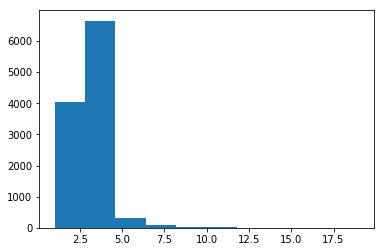

In [14]:
plt.hist(hand_counts)

{'whiskers': [<matplotlib.lines.Line2D at 0x11da08cc0>,
 'caps': [<matplotlib.lines.Line2D at 0x11da125c0>,
 'boxes': [<matplotlib.lines.Line2D at 0x11da08b70>],
 'medians': [<matplotlib.lines.Line2D at 0x11da12e10>],
 'fliers': [<matplotlib.lines.Line2D at 0x11da1b278>],
 'means': []}

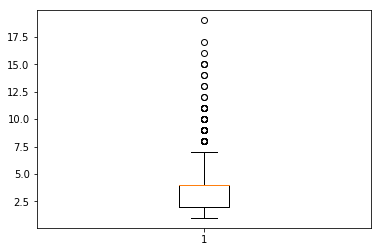

In [15]:
plt.boxplot(hand_counts)

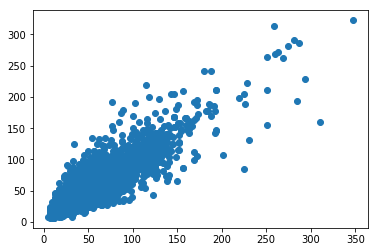

In [16]:
plt.scatter(x=train_hand_dimensions['width'], y=train_hand_dimensions['height'])

## Visualize Image Dimensions

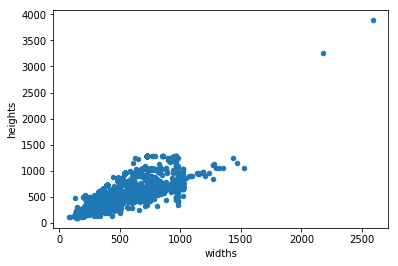

In [17]:
img_dimensions = pd.concat([train_img_dimensions, train_lisa_img_dimensions, test_img_dimensions, val_img_dimensions])
img_dimensions.plot.scatter('widths', 'heights')

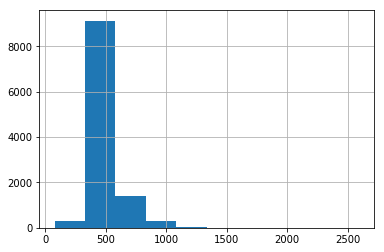

In [18]:
img_dimensions.widths.hist()

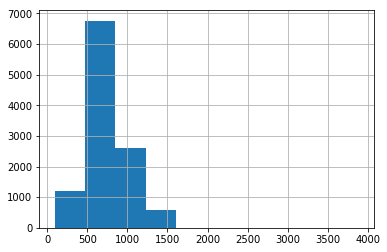

In [19]:
img_dimensions.heights.hist()

In [20]:
print('{} Total Train images'.format(len(train_images)))
print('{} Total Train annotations'.format(len(train_annotations)))
print('{} Total Train original filenames'.format(len(train_original_filenames)))
print()

print('{} Total Test images'.format(len(test_images)))
print('{} Total Test annotations'.format(len(test_annotations)))
print('{} Total Test original filenames'.format(len(test_original_filenames)))
print()

print('{} Total Validation images'.format(len(val_images)))
print('{} Total Validation annotations'.format(len(val_annotations)))
print('{} Total Validation original filenames'.format(len(val_original_filenames)))

9569 Total Train images
9569 Total Train annotations
9569 Total Train original filenames

821 Total Test images
821 Total Test annotations
821 Total Test original filenames

738 Total Validation images
738 Total Validation annotations
738 Total Validation original filenames


## Display

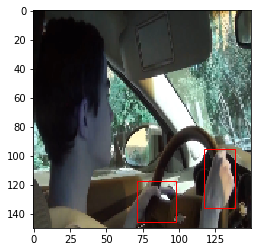

In [21]:
def display_image_with_annotation(img, annotations, ax = None):
    if ax is None:
        ax = plt.gca()
    plt.imshow(array_to_img(img))
    for annotation in annotations:
        line = plt.Polygon(annotation, fill=None, edgecolor='r')
        ax.add_patch(line)
    plt.show()

first_annotations_from_first_video = train_lisa_annotations[0]
first_image = train_lisa_images[0]
display_image_with_annotation(first_image, first_annotations_from_first_video)

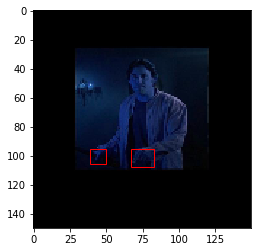

In [22]:
last_annotations_from_first_video = train_annotations[1]
last_image = train_images[1]
display_image_with_annotation(last_image, last_annotations_from_first_video)

### Save formatted images

In [23]:
def empty_directory(directory):
    for the_file in os.listdir(directory):
        file_path = os.path.join(directory, the_file)
        try:
            if os.path.isfile(file_path):
                os.unlink(file_path)
        except Exception as e:
            print(e)
def ensure_model_directory_exists(directory):
    try:
        os.makedirs(directory)
        print('Created directory {}'.format(directory))
    except:
        if CLEAR_EXISTING_IMAGES:
            print('Emptying directory {}'.format(directory))
            empty_directory(directory)
            

def save_images_and_annotations(images, filenames, annotations, directory):
    image_directory = os.path.join(directory, IMAGES_SUB_DIR)
    annotation_directory = os.path.join(directory, ANNOTATIONS_SUB_DIR)

    ensure_model_directory_exists(image_directory)
    ensure_model_directory_exists(annotation_directory)

    for image, filename, annotation in zip(images, filenames, annotations):
        image_file_path = os.path.join(image_directory, filename)
        annotation_file_path = os.path.join(annotation_directory, filename)
        cv2.imwrite(image_file_path, image)
        np.save(annotation_file_path, annotation)

save_images_and_annotations(train_images, train_original_filenames, train_annotations, NEW_HANDS_TRAIN)
save_images_and_annotations(test_images, test_original_filenames, test_annotations, NEW_HANDS_TEST)
save_images_and_annotations(val_images, val_original_filenames, val_annotations, NEW_HANDS_VAL)

Emptying directory ../../data/fabricated/hands_annotated_dataset/150X150/training/images
Emptying directory ../../data/fabricated/hands_annotated_dataset/150X150/training/annotations
Emptying directory ../../data/fabricated/hands_annotated_dataset/150X150/test/images
Emptying directory ../../data/fabricated/hands_annotated_dataset/150X150/test/annotations
Emptying directory ../../data/fabricated/hands_annotated_dataset/150X150/validation/images
Emptying directory ../../data/fabricated/hands_annotated_dataset/150X150/validation/annotations
